
# Goal:
predict `SalePrice` given 79 independent variables

# Data input and seperation:
the data is split into training and validation sets before any exploration to avoid train-test contamination

In [614]:
import pandas as pd
from sklearn.model_selection import train_test_split

# read in the data
trainingData = pd.read_csv("train.csv")
realData = pd.read_csv("test.csv")

# seperating the dataset into dependent and independent variables
y = trainingData.SalePrice
x = trainingData.drop('SalePrice', axis=1)
x = x.set_index('Id')
realData = realData.set_index('Id')

# split the data into a training set and a validation set
xTrain, xVal, yTrain, yVal = train_test_split(x, y,
                                                train_size=0.8, test_size=0.2,
                                                random_state=0)

# check that the shapes make sense
print("Size of OG data:", x.shape)
print("Size of training data:", xTrain.shape)
print("Size of val data:", xVal.shape)

# take a look at the training data
xTrain.head()

Size of OG data: (1460, 79)
Size of training data: (1168, 79)
Size of val data: (292, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,20,RL,90.0,11694,Pave,NaN,Reg,Lvl,AllPub,Inside,...,260,0,NaN,NaN,NaN,0,7,2007,New,Partial
871,20,RL,60.0,6600,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
93,30,RL,80.0,13360,Pave,Grvl,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
818,20,RL,NaN,13265,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal


# Exploring the data

In [615]:
xTrainNums = xTrain.select_dtypes(include=['int64', 'float64'])
xTrainStr = xTrain.select_dtypes(include=['object'])

print(xTrainNums.shape)
print(xTrainStr.shape)
# 36 + 43 = 79

(1168, 36)
(1168, 43)


There is two main types of data:
- numbers
- objects (strings)

## Exploring numeric data:

In [616]:
xTrainNums.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,774,0,108,0,0,260,0,0,7,2007
871,20,60.0,6600,5,5,1962,1962,0.0,0,0,...,308,0,0,0,0,0,0,0,8,2009
93,30,80.0,13360,5,7,1921,2006,0.0,713,0,...,432,0,0,44,0,0,0,0,8,2009
818,20,NaN,13265,8,5,2002,2002,148.0,1218,0,...,857,150,59,0,0,0,0,0,7,2008
303,20,118.0,13704,7,5,2001,2002,150.0,0,0,...,843,468,81,0,0,0,0,0,1,2006


### Cleaning up null entries:


In [617]:

# find the names of all the columns that contain no NaN values
noNaNCols = [col for col in xTrainNums.columns if not xTrainNums[col].isnull().any()]

xTrainNaN = xTrainNums.drop(noNaNCols, axis=1)

xTrainNaN.head()


,LotFrontage,MasVnrArea,GarageYrBlt
Id,,,
619,90.0,452.0,2007.0
871,60.0,0.0,1962.0
93,80.0,0.0,1921.0
818,NaN,148.0,2002.0
303,118.0,150.0,2001.0


nice, there is only 3 columns that contain NaN. They can be handled on a case by case basis:

- LotFrontage: Linear feet of street connected to property
- MasVnrArea: Masonry veneer area in square feet
- GarageYrBlt: Year garage was built

for now, I'll just use a simple imputer to replace NaN with the most frequent value

I think I'll graph them to get a better feel for what the best imputation is, or if it's even worth keeping them in the data set (if no correlation is observed, columns should be removed to minimize noise on the model)




percentage of elements in each column that is null:
LotFrontage    18.150685
MasVnrArea      0.513699
GarageYrBlt     4.965753
dtype: float64
LotFrontage


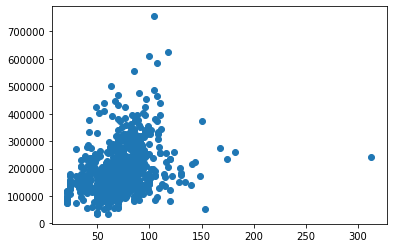

MasVnrArea


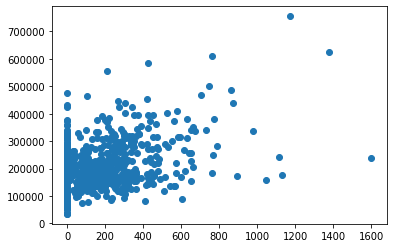

GarageYrBlt


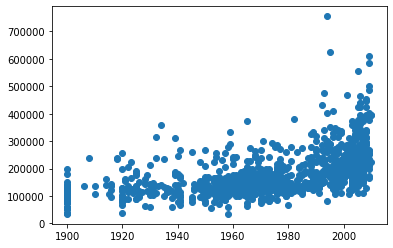

In [618]:
import matplotlib.pyplot as plt


# get the percentage of elements in each column that contains NaN
NaNratio = (xTrainNaN.isnull().sum()/len(xTrainNaN.index))*100
print("percentage of elements in each column that is null:",NaNratio, sep="\n")

# declare constants
LotFrontageMean = xTrainNaN.LotFrontage.mean()
MasVnrAreaMean = xTrainNaN.MasVnrArea.mean()

# replacing NaN in training data
xTrain = xTrain.fillna({
    'LotFrontage': LotFrontageMean,
    'MasVnrArea': MasVnrAreaMean,
     'GarageYrBlt': 1900
     })


# replacing NaN in validation data
xVal = xVal.fillna({
    'LotFrontage': LotFrontageMean,
    'MasVnrArea': MasVnrAreaMean,
     'GarageYrBlt': 1900
     })

# replacing NaN in real data
realData = realData.fillna({
    'LotFrontage': LotFrontageMean,
    'MasVnrArea': MasVnrAreaMean,
     'GarageYrBlt': 1900
     })


# visualizing the data:
for col in xTrainNaN:
    print(col)
    plt.scatter(xTrain[col], yTrain)
    plt.show()

# plt.scatter(xTrainNaN.GarageYrBlt, yTrain)

- LotFrontage: use of most_frequent slightly decreases the correlation. Use of mean or median has a negligable effect
- MasVnrArea: negligable due to it's relatively low null ratio
- GarageYrBlt: again, mean and median are almost identical. 
    - it is worth noting that the price of houses with null GarageYrBlt have a significantly low average price in contrast to the rest of the houses, which probably implies that these houses don't have a garage. A constant of about 1900 seems to fit the data the best
    
    


All three of the columns above do have some correlation with price, so I will keep all of them


### Chosing which numeric columns to drop:
low correlation columns should be dropped to reduce noise. I might come back to these and add more during model tuning phase

In [619]:

# cols2Drop = ['LowQualFinSF', # very low correlation
#              'PoolArea', # only 3 non-zero data points
#              'BsmtFinSF2', # low correlation
#              '3SsnPorch', # low number of non-zero values
# ]

# xTrainNumsClean2 = xTrainNumsClean.drop(cols2Drop, axis=1)
# xTrain = xTrain.drop(cols2Drop, axis=1)
# xVal = xVal.drop(cols2Drop, axis=1)
# realData = realData.drop(cols2Drop, axis=1)


# for col, srs in xTrainNumsClean2.items():
#     print(col)
#     plt.scatter(srs, yTrain)
#     plt.show()

## Exploring String data:

In [620]:
xTrainStr.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,New,Partial
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,PosN,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [621]:
# Categorical columns in the training data
colsObj = xTrainStr.columns

# Columns that can be safely ordinal encoded
goodLabels = [col for col in colsObj if set(xVal[col]).issubset(set(xTrain[col]))]

# Problematic columns that will be dropped from the dataset
badLabels = list(set(colsObj)-set(goodLabels))

In [622]:
from sklearn.preprocessing import OrdinalEncoder


# Drop categorical columns that will not be encoded
xTrainLabel = xTrain.drop(badLabels, axis=1)
xValLabel = xVal.drop(badLabels, axis=1)
realDataLabel = realData.drop(badLabels, axis=1)

# Apply ordinal encoder 
ordEncd = OrdinalEncoder()
xTrainLabel[goodLabels] = ordEncd.fit_transform(xTrain[goodLabels])
xValLabel[goodLabels] = ordEncd.transform(xVal[goodLabels])
realDataLabel[goodLabels] = ordEncd.fit_transform(realData[goodLabels])



## The Model:

In [623]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error


model = XGBRegressor(n_estimators=10000000, learning_rate=0.01)
model.fit(xTrainLabel, yTrain, 
             early_stopping_rounds=20, 
             eval_set=[(xValLabel, yVal)], 
             verbose=False)


# Mean Absolute Error:  16509.113174229453
# Mean Squared Log Error:  0.016473441198696676

pred = model.predict(xValLabel)
print("Mean Absolute Error: ", mean_absolute_error(pred, yVal))
print("Mean Squared Log Error: ", mean_squared_log_error(pred, yVal))

# The final prediction

In [ ]:
realPredictions = model.predict(realDataLabel)

# Save test predictions to file
output = pd.DataFrame({'Id': realDataLabel.index,
                       'SalePrice': realPredictions})
output.to_csv('submission.csv', index=False)